Hello! Thank you for your interest in drift rates! Please don't hesitate to email me (megangrace@ucla.edu) if you have comments/suggestions. This notebook includes a sample run of the code on the wonderful exoplanet, K2-18 B.

In [1]:
#general utility packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#nice modules from astropy
import astropy.units as u
import astropy.constants as const

#remind matplotlib how to do 3D plotting
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#builds very nice elliiptical orbits
!pip install PyAstronomy
import PyAstronomy
from PyAstronomy import pyasl

### Drift Rates Function

The drift_rates function is the only computing function in the entire notebook. First, it builds an elliptical orbit based on the 7 orbital parameters and then samples this orbit num_timestep times. These samples return radial components, which are plugged into the gravitational accleration equation (GM/r^2) to get an acceleration at each of these points. Then, the function projects these acceleration vectors along the axis between the transmitter and the observer (Earth), and returns 200 scalar drift rates for each planet.


Semimajor axis is in AU


Stellar mass is in Solar masses


Period is in days


e is the eccentricity of the orbit


omega is longitude of ascending node in degrees


i is inclination in degrees


w is argument is periapse in degrees


num_timestep is the number of data points to build the ellipse, I've been using 200

In [17]:
G = const.G
c = 3 * 10**8
def drift_rates(semimajor, period, e, omega, i, w, stellar_mass, num_timestep):
    ke = pyasl.KeplerEllipse(semimajor, period, e, Omega = omega,i = i,w = w)
    # Build the ellipse
    t = np.linspace(0, period, num_timestep)
    # Make a time axis
    pos = ke.xyzPos(t)
    radius = ke.radius(t)
    total_acc = G*stellar_mass*u.Msun/(radius* u.au)**2
    z_acceleration_array = []
    vector_to_earth = [0,0,1]
    for i in range(0, num_timestep):
        position_vector = ke.xyzPos(t)[i,:]
        radius = ke.radius(t)
        # vector from the origin (host star) to the point in the orbit
        z_magnitude = np.dot(vector_to_earth, position_vector) / radius[i]
        # normalized magnitude of the vector in the observer's direction - between -1 and 1
        z_acceleration_array.append((z_magnitude * total_acc[i].si).value/c)
    return z_acceleration_array

## K2-18 B

I got these numbers from Sarkis et al 2018 and Cloutier et al 2017 as listed in this [database](https://exoplanetarchive.ipac.caltech.edu/overview/%20K2-18%20b#planet_K2-18-b_collapsible)

The stellar mass of K2-18 is taken to be 0.359 Solar Masses.

(Planet Name : semimajor axis, period, eccentricity, longitude of ascending node, inclination, argument of periastron)

K2-18B : 0.1429, 32.94, 0.2, N/A, 89.6, 354.3

Since we do not have a value for longitude of ascending node, I will run 4 simulations on 0, 90, 180, and 270 degrees.

In [46]:
#list of LOAN's to iterate over
loan_list = [0, 90, 180, 270]

#will save all of the drift rates here
for loan in loan_list:
    drift_rates_df = pd.DataFrame(drift_rates(0.1429, 32.94, 0.2, loan, 89.6, 354.3, 0.359, 200), columns = ['drift_rates'])
    print(loan)
    drift_rates_df.to_csv('K2-18b_drift_rates_loan' + str(loan) +'.csv', index = False)
    

0
90
180
270


In [47]:
loan_0 = pd.read_csv('K2-18b_drift_rates_loan0.csv')
loan_90 = pd.read_csv('K2-18b_drift_rates_loan90.csv')
loan_180 = pd.read_csv('K2-18b_drift_rates_loan180.csv')
loan_270 = pd.read_csv('K2-18b_drift_rates_loan270.csv')

I don't think it will make much of a difference but I will plot the LOAN's separately first and then concatenate and take percentiles.

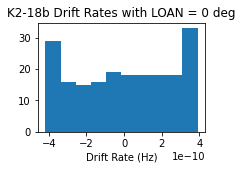

<Figure size 432x288 with 0 Axes>

In [48]:
plt.figure(figsize=[3,2])
plt.title('K2-18b Drift Rates with LOAN = 0 deg')
plt.hist(loan_0)
plt.xlabel('Drift Rate (Hz)')
plt.show()
plt.savefig('K2-18b_loan0.png')

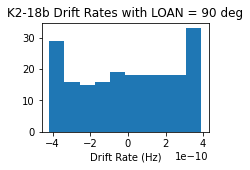

<Figure size 432x288 with 0 Axes>

In [49]:
plt.figure(figsize=[3,2])
plt.title('K2-18b Drift Rates with LOAN = 90 deg')
plt.hist(loan_90)
plt.xlabel('Drift Rate (Hz)')
plt.show()
plt.savefig('K2-18b_loan90.png')

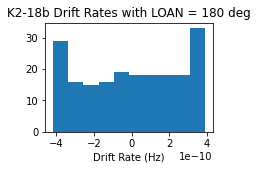

<Figure size 432x288 with 0 Axes>

In [50]:
plt.figure(figsize=[3,2])
plt.title('K2-18b Drift Rates with LOAN = 180 deg')
plt.hist(loan_180)
plt.xlabel('Drift Rate (Hz)')
plt.show()
plt.savefig('K2-18b_loan180.png')

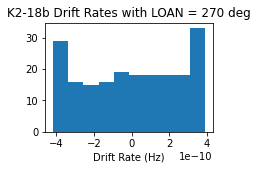

<Figure size 432x288 with 0 Axes>

In [51]:
plt.figure(figsize=[3,2])
plt.title('K2-18b Drift Rates with LOAN = 270 deg')
plt.hist(loan_180)
plt.xlabel('Drift Rate (Hz)')
plt.show()
plt.savefig('K2-18b_loan270.png')

The changes in LOAN appear to have made 0 difference. Likely because the inclination of this planet is very near 90 degrees.

In [52]:
def percentage_of_central_values(percent, list_):
    #This function will provide bounds on the histogram for an any percent of the values
    sorted_list = sorted(abs(list_))
    number_of_entries = round(len(list_) * percent/100)
    central_values = sorted_list[0:number_of_entries]
    return central_values

In [67]:
print('99\% of the drift rates should be encompassed by +\-' + str(percentage_of_central_values(99, np.array(loan_0['drift_rates'].to_list()))[-1]))
print('90\% of the drift rates should be encompassed by +\-' + str(percentage_of_central_values(90, np.array(loan_0['drift_rates'].to_list()))[-1]))
print('80\% of the drift rates should be encompassed by +\-' + str(percentage_of_central_values(80, np.array(loan_0['drift_rates'].to_list()))[-1]))
print('70\% of the drift rates should be encompassed by +\-' + str(percentage_of_central_values(70, np.array(loan_0['drift_rates'].to_list()))[-1]))

99\% of the drift rates should be encompassed by +\-4.1768750546809477e-10
90\% of the drift rates should be encompassed by +\-3.888402578721064e-10
80\% of the drift rates should be encompassed by +\-3.6378330024073766e-10
70\% of the drift rates should be encompassed by +\-3.2601839069172926e-10
